In [4]:
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import copy, random
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objs as go

In [5]:
DEVICES_NAMES=['tablet', 'personal phone','laptop', 'computer',
         'workstation', 'fridge', 'toaster', 'profesional phone',
        "mom's laptop", "old tablet", "connected table", "connected cat"]
DEVICES_PROBA=[ 10, 20, 14, 6,
                13, 3, 1, 10,
                2, 1, 6, 2]

In [6]:
def get_devices_names(n_devices):
    if n_devices <= 0:
        return []
    if n_devices <= len(DEVICES_NAMES):
        return copy.deepcopy(DEVICES_NAMES[:n_devices])
    else:
        devices_names=copy.deepcopy(DEVICES_NAMES)
        
        for m in range(2, 2+int(np.ceil(n_devices / len(DEVICES_NAMES)))):
            for i, name in enumerate(DEVICES_NAMES):
                if len(devices_names) < n_devices:
                    devices_names.append("{} {}".format(name, m))
                else:
                    return devices_names
                
def get_devices_proba(n_devices):
    devices_proba=[]
    if n_devices <= 0:
        return []
    if n_devices <= len(DEVICES_PROBA):
        devices_proba=copy.deepcopy(DEVICES_PROBA[:n_devices])
    else:
        devices_proba=copy.deepcopy(DEVICES_PROBA)
        
        for _ in range(int(np.ceil(n_devices / len(DEVICES_NAMES)))):
            for i in range(len(DEVICES_PROBA)):
                if len(devices_proba) < n_devices:
                    devices_proba.append(DEVICES_PROBA[i])
                else:
                    break
            
            if len(devices_proba) >= n_devices:
                break
    
    total=np.sum(devices_proba)
    for i in range(len(devices_proba)):
        devices_proba[i]/=total
    
    return devices_proba

class zipf_gen:
    def __init__(self, N, s):
        self.N = N
        self.s = s
        self.harmonic = 1/np.sum( np.power( np.arange(1, self.N+1, dtype=float), -self.s ) )
        self._pmf = self.harmonic / np.arange(1, self.N+1) ** self.s
        
        if np.sum(self._pmf) != 1.:
            #print("PMF does not sum to 1 ({}).".format(np.sum(self._pmf)))
            self._pmf[0] += 1. - np.sum(self._pmf)
            #print("New PMF sum value:", np.sum(self._pmf))
    
    def pmf(self):
        return self._pmf
    
    def draw(self):
        return np.random.choice(np.arange(1, self.N+1), p=self._pmf)

In [7]:
def is_connected(W):
    n_devices=len(W)
    G=nx.DiGraph()

    G.add_nodes_from(list(range(n_devices)))

    for i in range(n_devices):
        for j in range(n_devices):
            if W[i][j] == 0:
                continue
            G.add_edge(i, j)

    return nx.is_semiconnected(G)

In [8]:
def generate_uniform_transition_matrix(n_devices):
    return np.full((n_devices, n_devices), 1/n_devices)

SEQUENCE_LENGTH=100
def generate_transition_matrix_from_sequence(n_devices, sequence_length=SEQUENCE_LENGTH):
    devices_proba=get_devices_proba(n_devices)
    S=[]
    connected = False
    
    while not connected:
        W=np.zeros((n_devices, n_devices), dtype=np.float)
        S=[np.random.choice(a=range(n_devices), p=devices_proba) for _ in range(sequence_length)]
        
        for i in range(sequence_length-1):
            W[S[i], S[i+1]]+=1
            
        if not is_connected(W):
            continue
        else:
            connected=True
        
        W=(W.T/W.sum(axis=1)).T
        W=np.nan_to_num(W)
        
    print(S)
    
    return W

S_MIN=1
S_MAX=4
def generate_zipf_transition_matrix(n_devices, s_min=S_MIN, s_max=S_MAX):
    W=np.zeros((n_devices, n_devices), dtype=np.float)
    
    for i in range(n_devices):
        zipf=zipf_gen(N=n_devices, s=random.uniform(s_min, s_max))
        W[i, :] = np.random.permutation(zipf.pmf())
        #print("Line {} has s={}".format(i, zipf.s))
        
    return W

def generate_sparse_transition_matrix_from_zipf(n_devices, N=1000, s=1.8):
    # The bigger N, the bigger the potential gap b/w smallest an biggest probability
    # The bigger s, the least non-zero probabilities
    
    zipf=zipf_gen(N=N, s=s)
    connected = False
    
    while not connected:
        W=np.zeros((n_devices, n_devices), dtype=np.float)
        
        for i in range(n_devices):
            drawn=[zipf.draw()-1 for _ in range(n_devices)]
            while np.count_nonzero(drawn) == 0:
                drawn=[zipf.draw()-1 for _ in range(n_devices)]

            W[i, :] = drawn / np.sum(drawn)
        
        connected = is_connected(W)
        
    return W

def generate_cyclic_transition_matrix(n_devices):
    W=np.zeros((n_devices, n_devices), dtype=np.float)
    
    for i in range(n_devices):
        j = (i+1) % n_devices
        W[i][j] = 1
        
    return W
    
def generate_device_use_model(n_devices, model_type, **kwargs):
    if model_type == "uniform":
        return generate_uniform_transition_matrix(n_devices)
    elif model_type == "from_sequence":
        return generate_transition_matrix_from_sequence(n_devices, **kwargs)
    elif model_type == "zipf":
        return generate_zipf_transition_matrix(n_devices, **kwargs)
    elif model_type == "sparse":
        return generate_sparse_transition_matrix_from_zipf(n_devices, **kwargs)
    elif model_type == "cyclic":
        return generate_cyclic_transition_matrix(n_devices)
    else:
        print("Infalid model type.")

In [9]:
W=generate_device_use_model(12, "sparse", s=1.5)
W

array([[ 0.        ,  0.03703704,  0.03703704,  0.        ,  0.03703704,
         0.        ,  0.22222222,  0.        ,  0.        ,  0.        ,
         0.51851852,  0.14814815],
       [ 0.        ,  0.05442177,  0.23129252,  0.        ,  0.        ,
         0.        ,  0.00680272,  0.02040816,  0.        ,  0.00680272,
         0.66666667,  0.01360544],
       [ 0.00873362,  0.        ,  0.        ,  0.0349345 ,  0.        ,
         0.0349345 ,  0.        ,  0.00436681,  0.00873362,  0.        ,
         0.90829694,  0.        ],
       [ 0.01315789,  0.03947368,  0.01315789,  0.        ,  0.39473684,
         0.03947368,  0.19736842,  0.01315789,  0.        ,  0.05263158,
         0.01315789,  0.22368421],
       [ 0.00980392,  0.01633987,  0.00326797,  0.00326797,  0.00653595,
         0.00326797,  0.02287582,  0.        ,  0.83333333,  0.02287582,
         0.06862745,  0.00980392],
       [ 0.        ,  0.        ,  0.        ,  0.03278689,  0.68852459,
         0.1147541 ,  

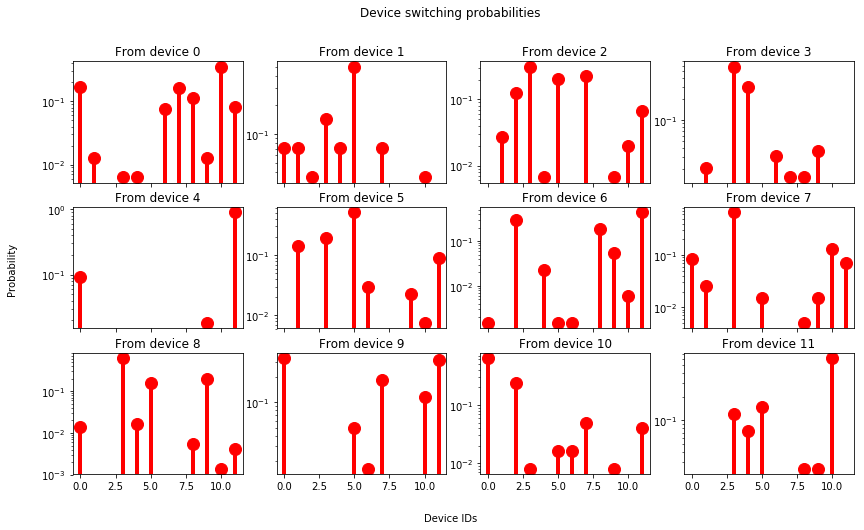

In [7]:
n_devices=12

def plot_model_probabilities(W, fn="plots/W_probabilities.svg"):
    n_devices=len(W)
    xaxis=list(range(n_devices))

    n_cols=int(np.ceil(np.sqrt(n_devices)))
    n_rows=int(np.ceil(n_devices/n_cols))


    plt.clf()
    fig, axarr = plt.subplots(n_rows, n_cols, sharex=True, figsize=(3.5*n_cols,1+2.2*n_rows))
    fig.suptitle("Device switching probabilities")
    fig.text(0.5, 0.04, 'Device IDs', ha='center')
    fig.text(0.06, 0.5, 'Probability', va='center', rotation='vertical')

    for i, w in enumerate(W):
        col = i % n_cols
        row = i // n_cols

        #fig, ax = plt.subplots(1, 1)
        #zipf_pmf=[my_zipf.pmf(k=k, s=s, N=N) for k in xk]
        axarr[row,col].plot(xaxis, w, 'ro', ms=12, mec='r')
        axarr[row,col].vlines(xaxis, 0, w, colors='r', lw=4)
        axarr[row,col].set_yscale('log')
        #axarr[row,col].set_title("device {}: max={}, min={}".format(i, np.max(w), np.min(w)))
        axarr[row,col].set_title("From device {}".format(i))
        #axarr[row,col].set_xlabel("lala")

    plt.savefig(fn)
    plt.show()
    
plot_model_probabilities(W, fn="plots/W_sparse_s1.5.svg")

In [10]:
model.write_dot_markov_chain(W)

In [352]:
is_connected(W)

True

In [16]:
def write_dot_markov_chain(W, fn="markov/mc.dot"):
    # Code taken here: http://vknight.org/unpeudemath/code/2015/11/15/Visualising-markov-chains.html
    n_devices = len(W)
    devices_names=get_devices_names(n_devices)
    
    G = nx.MultiDiGraph(name="Alice's devices")
    for i, name in enumerate(devices_names):
        G.add_node(i, label=name)
    #G.add_nodes_from(DEVICES_NAMES)

    for i, origin_state in enumerate(devices_names):
        for j, destination_state in enumerate(devices_names):
            rate = W[i][j]
            if rate > 0:
                G.add_edge(i,
                           j,
                           weight=rate,
                           # For clarity when drawing edge labels
                           #decorate=True,
                           label="{:.0%}".format(rate))
                
    write_dot(G, fn)
    
write_dot_markov_chain(W)